In [376]:
# import bibs
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

# Loading data

In [377]:
working_directory = os.getcwd()
path = working_directory
path

'/Users/kseniablokhina/Downloads/Data-Driven-Modeling-WS24-25/notebooks'

In [ ]:
gdp_data = pd.read_pickle("./data/raw/gdp.pickle")
df_pattern = pd.read_pickle("./data/raw/naics_pattern.pickle")

df_occupation_1 = pd.read_pickle("./data/raw/naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle("./data/raw/naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle("./data/raw/naics_occupation_part3.pickle")

In [379]:
df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)
unique_lengths = df_pattern['FIPS'].apply(len).unique()
unique_lengths

array([4, 5])

In [380]:
def add_zeros(code):
    code = str(code)
    if len(code) == 3:
        return '00' + code
    elif len(code) == 4:
        return '0' + code
    elif len(code) == 1:
        return '0000' + code
    return code

In [381]:
df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [382]:
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head(2)

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN


# Feature overview

In [23]:
gdp_data.columns

Index(['FIPS', 'GeoName', 'Region', 'TableName', 'LineCode',
       'IndustryClassification', 'Description', 'Unit', '2017', '2018', '2019',
       '2020', '2021', '2022'],
      dtype='object')

**One feature (GDP) for the years 2017 to 2022**

In [24]:
df_pattern.columns

Index(['State_GEOID', 'County_GEOID', 'FIPS', 'naics_2', 'naics',
       'DESCRIPTION', 'emp_nf', 'emp', 'qp1_nf', 'qp1', 'ap_nf', 'ap', 'est',
       'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4'],
      dtype='object')

**Features:**

- **emp:** employment + noise flag
- **qp1:** first quarter payroll + noise flag
- **ap:** anual payroll + noise flag
- **est:** number of establishments (total and for different employment sizes)

In [25]:
df_occupation.columns

Index(['FIPS', 'State_GEOID', 'naics', 'NAICS_TITLE', 'emp_total_county_naics',
       'OCC_CODE', 'OCC_TITLE', 'emp_occupation', 'state_name'],
      dtype='object')

**Features:**

- **emp_total_county_naics:** total emplyment for all existing NAICS Codes
- **emp_occupation:** specific employment for specific combination of occupation and industry

# Feature selection 

We will select an exemplary feature in this code.<br>  

We will focus on the feature **number of companies (est)**. Regions where specific industries are located or concentrated will usually also consume tools.

In [26]:
df_pattern.head(3)

,State_GEOID,County_GEOID,FIPS,naics_2,naics,DESCRIPTION,emp_nf,emp,qp1_nf,qp1,...,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4
0,01,001,01001,11,1133,Logging,G,68,G,1213,...,N,N,N,N,N,N,N,N,N,N
1,01,001,01001,21,2123,Nonmetallic Mineral Mining and Quarrying,G,87,G,1224,...,N,N,N,N,N,N,N,N,N,N
2,01,001,01001,22,2211,"Electric Power Generation, Transmission and Di...",G,129,G,4418,...,N,N,N,N,N,N,N,N,N,N


In [27]:
result = df_pattern.groupby(['naics', 'DESCRIPTION']).agg(
    est_sum=('est', 'sum'),             # Summe der Werte in der Spalte 'Wert'
    unique_FIPS=('FIPS', 'nunique')  # Anzahl eindeutiger Werte in der Spalte 'Kategorie'
).sort_values(by='est_sum', ascending=False)
result.head(40)

,,est_sum,unique_FIPS
naics,DESCRIPTION,,
5617,Services to Buildings and Dwellings,220492,2530
2382,Building Equipment Contractors,193562,2756
8111,Automotive Repair and Maintenance,164584,2725
2383,Building Finishing Contractors,124074,2040
5413,"Architectural, Engineering, and Related Services",115269,1924
2381,"Foundation, Structure, and Building Exterior Contractors",101383,2313
7139,Other Amusement and Recreation Industries,76488,2182
4413,"Automotive Parts, Accessories, and Tire Stores",58112,2427
5613,Employment Services,57057,1306


What is NAICS 3320A2 ? -- 3323, 3323

https://www.bls.gov/oes/2023/may/naics4_3320A2.htm

Fabricated Metal Product Manufacturing (3323 and 3324 only)

- 3323: Architectural and Structural Metals Manufacturing
- 3324: Boiler, Tank, and Shipping Container Manufacturing

# Feature construction

**How do you choose the most important and relevant industries?**

Viewed as a whole, the project has requirements from various sides:
- Domain: tool consumption / employment
- Modeling: clustering

<br> For the **domain side**, it makes sense to choose industries that have a high share of employment and a high consumption of tools.
<br> For the **modeling side**, it makes sense to cover as many regions as possible. Since we will later use a maximum of 15 features, it makes no sense to select industries that only occur in a very small number of regions. 

## Domain

### Tool consumption

Here, the individual industries must be evaluated by **domain knowledge** with regard to their potential tool consumption.<br>
We will insert random values between 0 and 10 as an example 

In [28]:
# Generate random values for each NAICS and assign them to each entry in the group 
random_values = {naics: np.random.randint(0, 11) for naics in df_pattern['naics'].unique()}
df_pattern['tool_consumption'] = df_pattern['naics'].map(random_values)
df_pattern.head(3)

,State_GEOID,County_GEOID,FIPS,naics_2,naics,DESCRIPTION,emp_nf,emp,qp1_nf,qp1,...,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4,tool_consumption
0,01,001,01001,11,1133,Logging,G,68,G,1213,...,N,N,N,N,N,N,N,N,N,10
1,01,001,01001,21,2123,Nonmetallic Mineral Mining and Quarrying,G,87,G,1224,...,N,N,N,N,N,N,N,N,N,8
2,01,001,01001,22,2211,"Electric Power Generation, Transmission and Di...",G,129,G,4418,...,N,N,N,N,N,N,N,N,N,9


### Share of Employment

In [29]:
df_pattern.groupby(['naics', 'DESCRIPTION']).agg(
    emp_sum=('emp', 'sum')             # Sum of values in the 'emp' column
      ).sort_values(by='emp_sum', ascending=False)

,,emp_sum
naics,DESCRIPTION,
5613,Employment Services,7061425
2382,Building Equipment Contractors,2171001
5617,Services to Buildings and Dwellings,2004960
5413,"Architectural, Engineering, and Related Services",1579218
4411,Automobile Dealers,1245435
...,...,...
3313,Alumina and Aluminum Production and Processing,20149
3132,Fabric Mills,18615
4862,Pipeline Transportation of Natural Gas,18442


## Modeling 

### Unique FIPS

In [30]:
df_pattern.groupby(['naics', 'DESCRIPTION']).agg(
    unique_FIPS=('FIPS', 'nunique')            # Count of unique values in the 'FIPS' column
      # Count of unique values in the 'category' column
).sort_values(by='unique_FIPS', ascending=False)

,,unique_FIPS
naics,DESCRIPTION,
2382,Building Equipment Contractors,2756
8111,Automotive Repair and Maintenance,2725
5617,Services to Buildings and Dwellings,2530
4413,"Automotive Parts, Accessories, and Tire Stores",2427
2381,"Foundation, Structure, and Building Exterior Contractors",2313
...,...,...
3313,Alumina and Aluminum Production and Processing,36
3311,Iron and Steel Mills and Ferroalloy Manufacturing,34
2122,Metal Ore Mining,32


## Ranking

In [31]:
result = df_pattern.groupby(['naics', 'DESCRIPTION', 'tool_consumption']).agg(
    emp_sum=('emp', 'sum'),            # Sum of values in the 'emp' column
    unique_FIPS=('FIPS', 'nunique')    # Count of unique values in the 'FIPS' column
).sort_values(by='emp_sum', ascending=False).reset_index()

# Display the first 40 rows
result.head(40)

,naics,DESCRIPTION,tool_consumption,emp_sum,unique_FIPS
0,5613,Employment Services,10,7061425,1306
1,2382,Building Equipment Contractors,3,2171001,2756
2,5617,Services to Buildings and Dwellings,3,2004960,2530
3,5413,"Architectural, Engineering, and Related Services",0,1579218,1924
4,4411,Automobile Dealers,4,1245435,1953
5,7139,Other Amusement and Recreation Industries,7,1092894,2182
6,8111,Automotive Repair and Maintenance,1,902870,2725
7,2381,"Foundation, Structure, and Building Exterior C...",3,901696,2313
8,2383,Building Finishing Contractors,6,811812,2040
9,4238,"Machinery, Equipment, and Supplies Merchant Wh...",2,739134,1947


In [32]:
# Create a copy of the DataFrame
result_copy = result.copy()

# Calculate rank for all columns starting from 'tool_consumption', with equal values having the same rank
for column in result_copy.columns[result_copy.columns.get_loc('tool_consumption'):]:
    rank_column_name = f'rank_{column}'
    result_copy[rank_column_name] = result_copy[column].rank(method='min', ascending=False).astype(int)

# Display the first few rows of the copied data
result_copy.head()

,naics,DESCRIPTION,tool_consumption,emp_sum,unique_FIPS,rank_tool_consumption,rank_emp_sum,rank_unique_FIPS
0,5613,Employment Services,10,7061425,1306,1,1,14
1,2382,Building Equipment Contractors,3,2171001,2756,43,2,1
2,5617,Services to Buildings and Dwellings,3,2004960,2530,43,3,3
3,5413,"Architectural, Engineering, and Related Services",0,1579218,1924,66,4,10
4,4411,Automobile Dealers,4,1245435,1953,36,5,8


In [33]:
weights = {
    'rank_tool_consumption': 0.5,   # Weight for the ranking column 'tool_consumption'
    'rank_emp_sum': 0.3,            # Weight for the ranking column 'emp_sum'
    'rank_unique_FIPS': 0.2         # Weight for the ranking column 'unique_FIPS'
}

In [34]:
# calculate the weighted sum
result_copy['Weighted_Sum'] = (result_copy['rank_tool_consumption'] * weights['rank_tool_consumption'] +
                          result_copy['rank_emp_sum'] * weights['rank_emp_sum'] +
                          result_copy['rank_unique_FIPS'] * weights['rank_unique_FIPS'])
result_sorted = result_copy.sort_values(by='Weighted_Sum', ascending=True)

In [35]:
result_sorted.head(10)

,naics,DESCRIPTION,tool_consumption,emp_sum,unique_FIPS,rank_tool_consumption,rank_emp_sum,rank_unique_FIPS,Weighted_Sum
0,5613,Employment Services,10,7061425,1306,1,1,14,3.6
13,4413,"Automotive Parts, Accessories, and Tire Stores",9,532828,2427,3,14,4,6.5
5,7139,Other Amusement and Recreation Industries,7,1092894,2182,12,6,6,9.0
16,2211,"Electric Power Generation, Transmission and Di...",9,451638,1274,3,17,16,9.8
18,4231,Motor Vehicle and Motor Vehicle Parts and Supp...,9,390199,1030,3,19,20,11.2
11,3261,Plastics Product Manufacturing,8,572426,763,7,12,27,12.5
8,2383,Building Finishing Contractors,6,811812,2040,17,9,7,12.6
23,3327,"Machine Shops; Turned Product; and Screw, Nut,...",7,332653,1276,12,24,15,16.2
31,3399,Other Miscellaneous Manufacturing,8,215641,900,7,32,23,17.7
20,3231,Printing and Related Support Activities,6,356146,1116,17,21,18,18.4


In [36]:
top5_industries = result_sorted[:5]['naics'].tolist()
top5_industries

['5613', '4413', '7139', '2211', '4231']

# feature_df

In [37]:
df_pattern.columns

Index(['State_GEOID', 'County_GEOID', 'FIPS', 'naics_2', 'naics',
       'DESCRIPTION', 'emp_nf', 'emp', 'qp1_nf', 'qp1', 'ap_nf', 'ap', 'est',
       'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4',
       'tool_consumption'],
      dtype='object')

In [38]:
# Assume `df` is the original DataFrame
# List of desired NAICS codes
naics_codes = top5_industries

# Create a new DataFrame with unique FIPS values
feature_df = pd.DataFrame(df_pattern['FIPS'].unique(), columns=['FIPS'])

# Add a new column with the corresponding 'est' values for each NAICS code
for naics_code in naics_codes:
    # Filter the rows for the current NAICS code and get the corresponding 'est' values
    est_values = df_pattern[df_pattern['naics'] == naics_code].set_index('FIPS')['est']
    
    # Merge the 'est' values as a new column in the new DataFrame
    feature_df = feature_df.merge(est_values, how='left', left_on='FIPS', right_index=True)
    
    # Rename the column based on the NAICS code
    feature_df = feature_df.rename(columns={'est': f'est_{naics_code}'})

# Display the result
feature_df

,FIPS,est_5613,est_4413,est_7139,est_2211,est_4231
0,01001,NaN,12.0,12.0,4.0,NaN
1,01003,18.0,54.0,69.0,4.0,5.0
2,01005,NaN,8.0,4.0,5.0,NaN
3,01007,NaN,7.0,NaN,NaN,NaN
4,01009,3.0,12.0,7.0,NaN,6.0
...,...,...,...,...,...,...
3066,56039,12.0,4.0,73.0,NaN,NaN
3067,56041,NaN,7.0,4.0,5.0,NaN
3068,56043,NaN,4.0,NaN,4.0,NaN
3069,56045,NaN,NaN,NaN,3.0,NaN


In [39]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071 entries, 0 to 3070
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FIPS      3071 non-null   object 
 1   est_5613  1306 non-null   float64
 2   est_4413  2427 non-null   float64
 3   est_7139  2182 non-null   float64
 4   est_2211  1274 non-null   float64
 5   est_4231  1030 non-null   float64
dtypes: float64(5), object(1)
memory usage: 144.1+ KB


# Scaling 

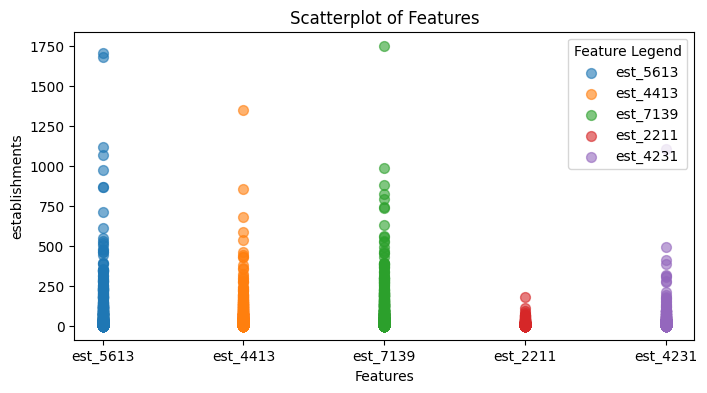

In [40]:
# Drop 'FIPS' column
feature_df_no_fips = feature_df.drop(columns='FIPS')

plt.figure(figsize=(8,4))

# Plot points without NaN values for each column except 'FIPS'
for col in feature_df_no_fips.columns:
    # Remove NaN values
    non_nan_data = feature_df_no_fips[col].dropna()
    plt.scatter([col] * len(non_nan_data), non_nan_data, s=50, alpha=0.6, label=col)  # Set s to a fixed value

plt.xlabel("Features")
plt.ylabel("establishments")
plt.title("Scatterplot of Features")
plt.legend(title="Feature Legend")
plt.show()


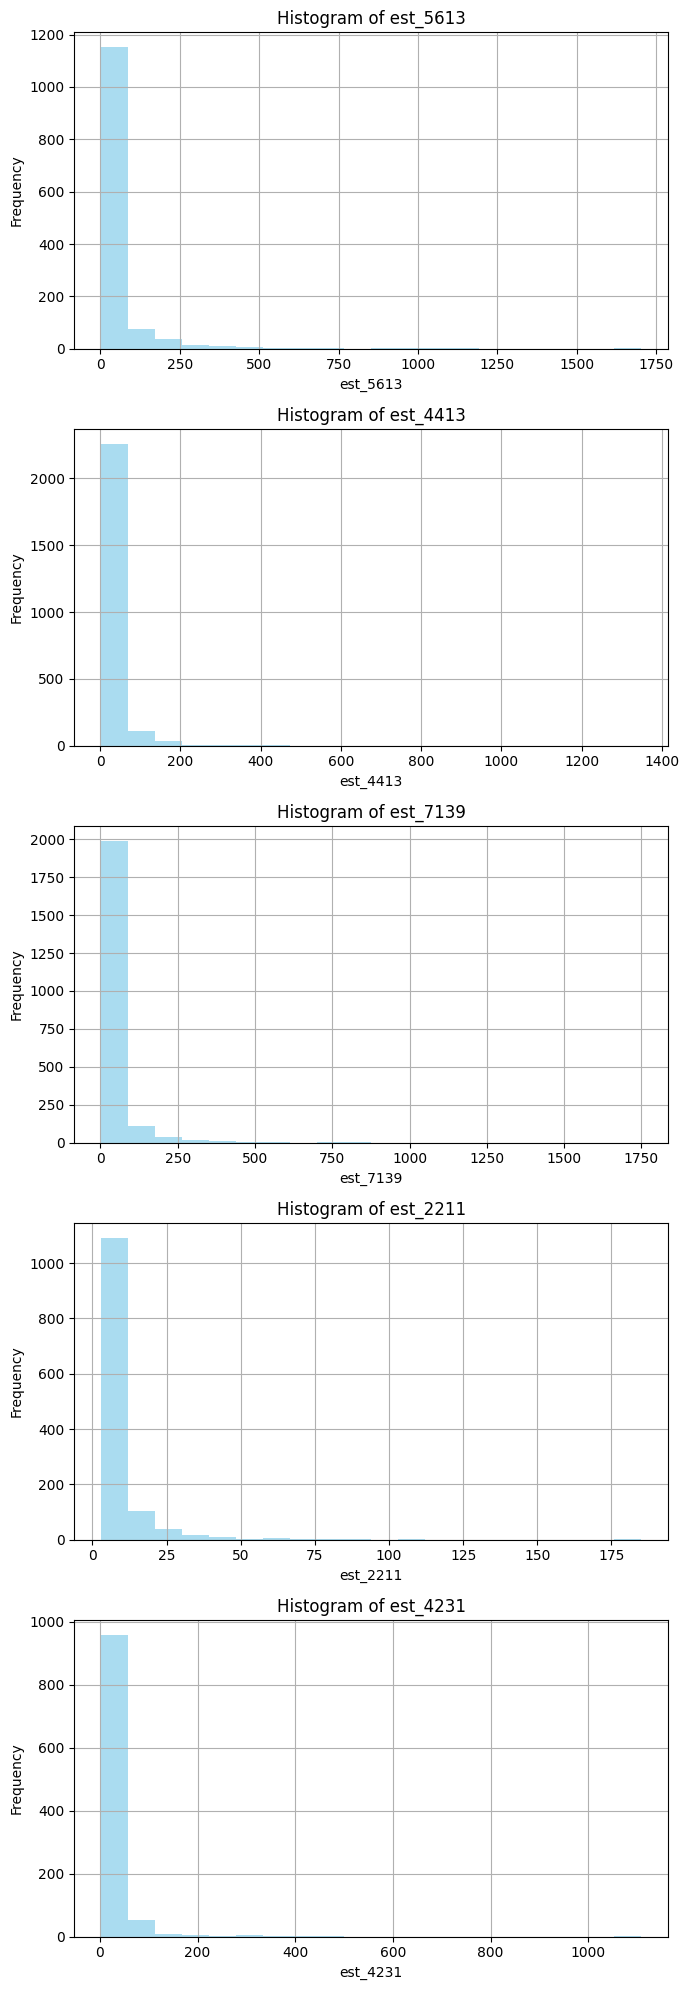

In [41]:
# Drop the 'FIPS' column
feature_df_no_fips = feature_df.drop(columns='FIPS')

# Number of columns (features)
n_features = len(feature_df_no_fips.columns)

# Set up subplots (one row and as many columns as there are features)
fig, axes = plt.subplots(n_features, 1, figsize=(7, 4 * n_features))

# Create a histogram for each feature
for i, col in enumerate(feature_df_no_fips.columns):
    axes[i].hist(feature_df_no_fips[col].dropna(), bins=20, alpha=0.7, color='skyblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

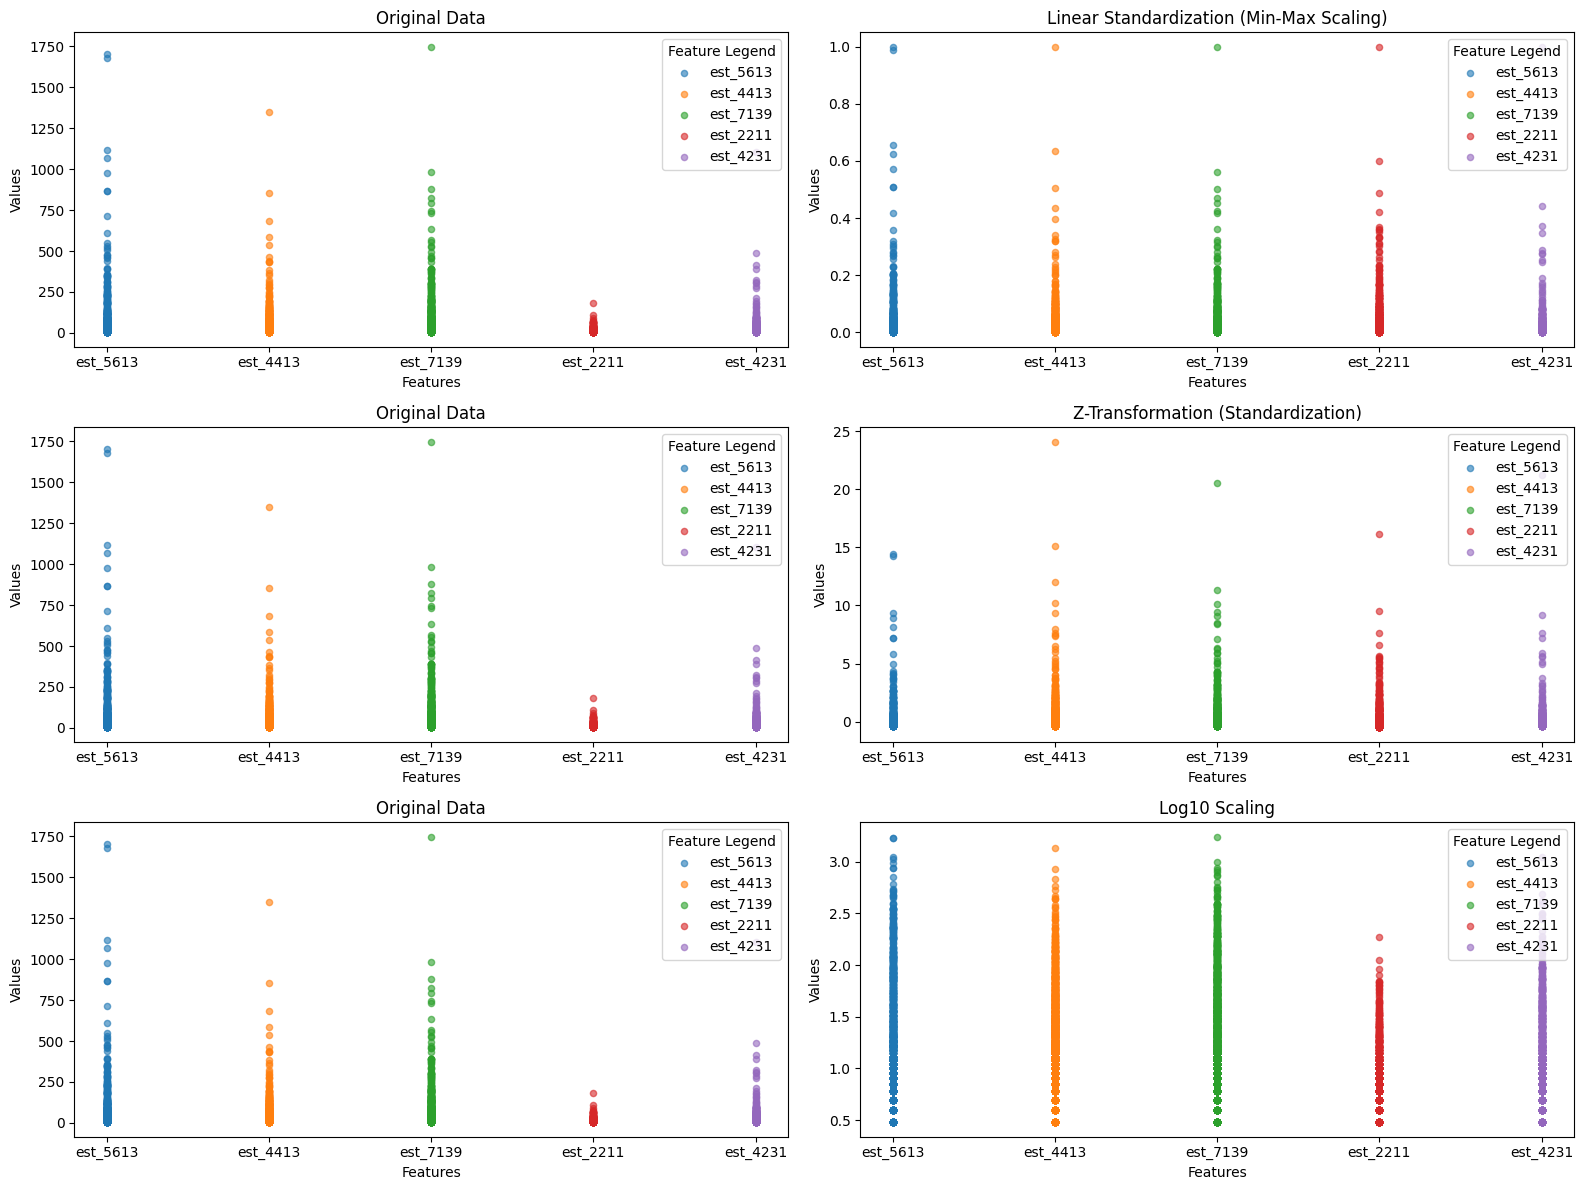

In [42]:
# Drop the 'FIPS' column
feature_df_no_fips = feature_df.drop(columns='FIPS')

# Linear Standardization (Min-Max Scaling)
scaler_minmax = MinMaxScaler()
feature_df_minmax = scaler_minmax.fit_transform(feature_df_no_fips)

# Z-transformation (Standardization)
scaler_standard = StandardScaler()
feature_df_zscore = scaler_standard.fit_transform(feature_df_no_fips)

# Log10 Scaling (with a small constant to avoid log(0))
feature_df_log10 = np.log10(feature_df_no_fips + 1e-9)

# Plotting function with automatic y-limits adjustment
def plot_features(data, title, ax):
    for i, col in enumerate(feature_df_no_fips.columns):
        non_nan_data = data[:, i][~np.isnan(data[:, i])]  # Get non-NaN data for each feature
        ax.scatter([col] * len(non_nan_data), non_nan_data, s=20, alpha=0.6, label=col)
    ax.set_xlabel("Features")
    ax.set_ylabel("Values")
    ax.set_title(title)
       

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharey=False)

# List of data pairs and titles for each subplot
data_pairs = [
    (feature_df_no_fips.to_numpy(), "Original Data", feature_df_minmax, "Linear Standardization (Min-Max Scaling)"),
    (feature_df_no_fips.to_numpy(), "Original Data", feature_df_zscore, "Z-Transformation (Standardization)"),
    (feature_df_no_fips.to_numpy(), "Original Data", feature_df_log10.to_numpy(), "Log10 Scaling")
]

# Plot each pair of datasets in the grid
for row, (original_data, original_title, transformed_data, transformed_title) in enumerate(data_pairs):
    # Plot original data in the left column
    plot_features(original_data, original_title, axes[row, 0])
    # Plot transformed data in the right column
    plot_features(transformed_data, transformed_title, axes[row, 1])

# Adjust layout and show legend for each subplot
for ax in axes.flat:
    if ax.has_data():
        ax.legend(title="Feature Legend", loc='upper right')
plt.tight_layout()
plt.show()


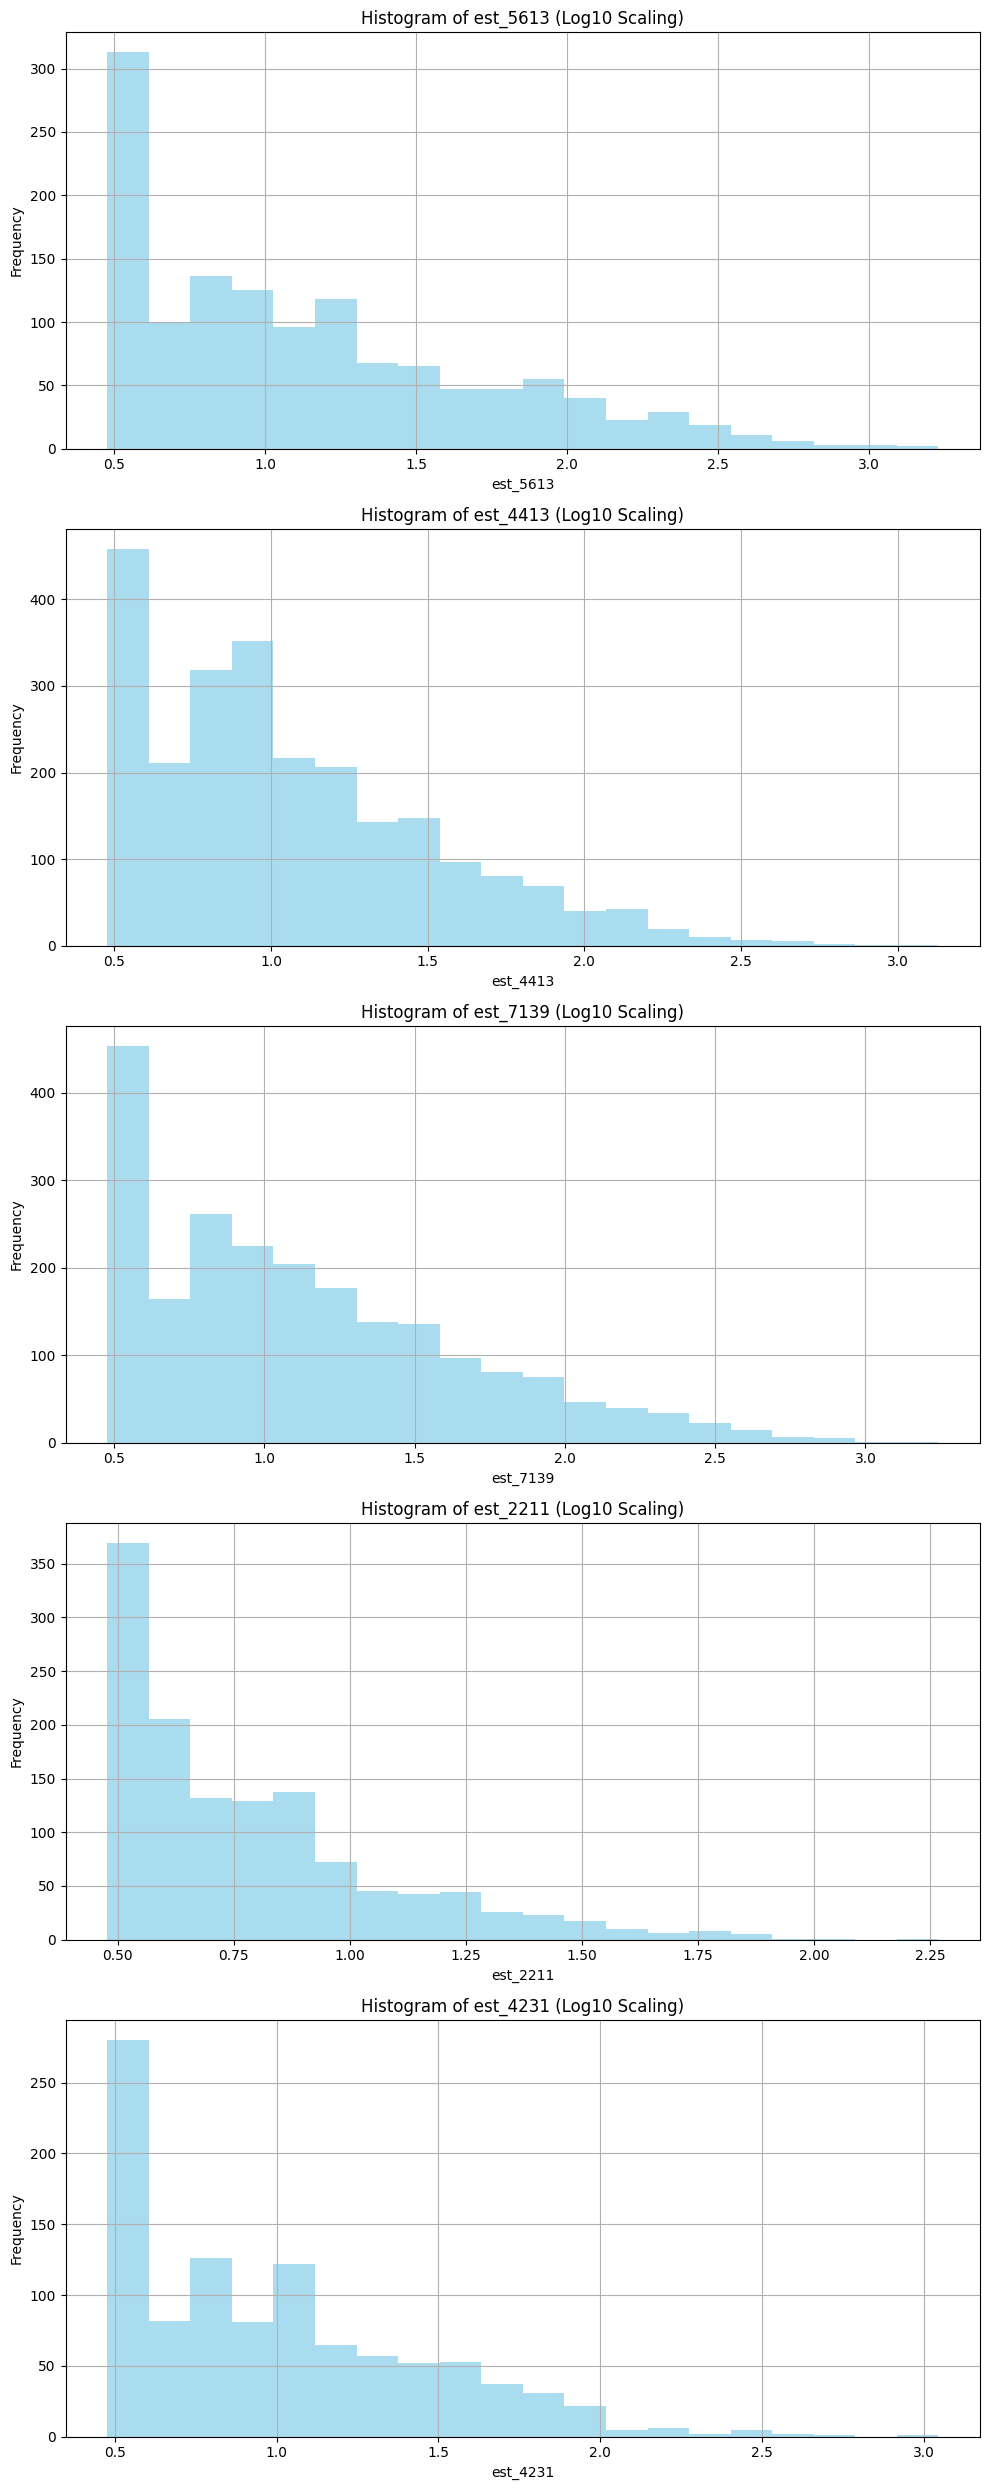

In [43]:
# Drop the 'FIPS' column
feature_df_no_fips = feature_df.drop(columns='FIPS')

# Log10 Scaling (with a small constant to avoid log(0))
feature_df_log10 = np.log10(feature_df_no_fips + 1e-9)

# Plotting function for histograms (only for log10 scaling)
def plot_histograms_log10(data):
    n_features = data.shape[1]
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 5 * n_features))

    # Loop through each feature and plot its histogram
    for i, col in enumerate(feature_df_no_fips.columns):
        axes[i].hist(data[:, i], bins=20, alpha=0.7, color='skyblue')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'Histogram of {col} (Log10 Scaling)')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Plot histograms for Log10 scaling
plot_histograms_log10(feature_df_log10.to_numpy())


# Dimension reduction

## PCA

In [44]:
# Replace NaN values with 0
feature_df_filled = feature_df_log10.fillna(0)

# Initialize PCA and fit it to the filled DataFrame
n_components = 2  # Number of principal components, adjust as needed
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(feature_df_filled)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Optional: Print the explained variance ratio of each component
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.80791082 0.07638147]


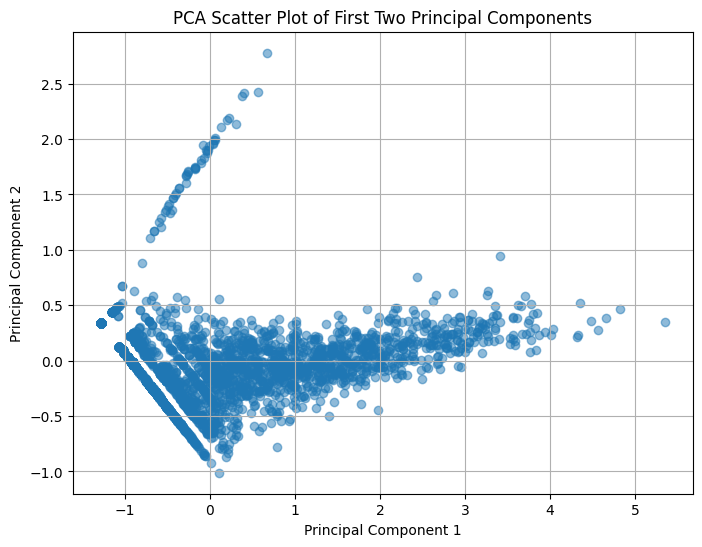

In [45]:
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot of First Two Principal Components')
plt.grid(True)
plt.show()

## SVD

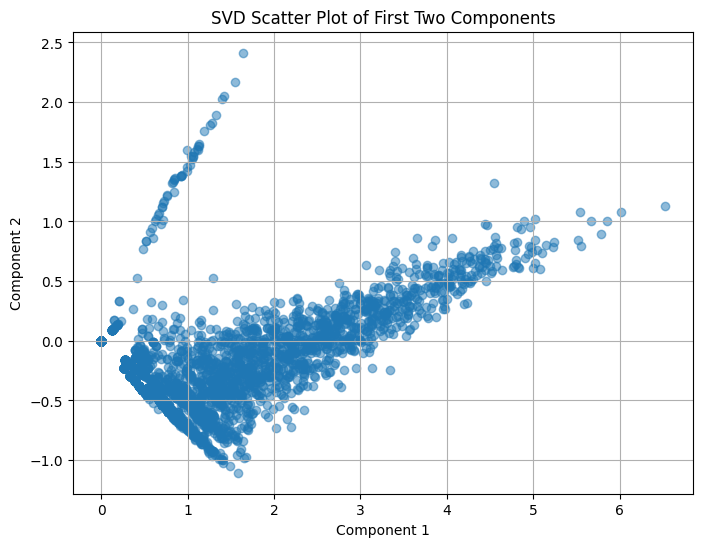

In [46]:
# Replace NaN values with 0
feature_df_filled = feature_df_log10.fillna(0)

# Initialize SVD and fit it to the DataFrame
n_components = 2  # Number of desired components
svd = TruncatedSVD(n_components=n_components)
svd_components = svd.fit_transform(feature_df_filled)

# Create a DataFrame with the SVD results
svd_df = pd.DataFrame(data=svd_components, columns=['Component 1', 'Component 2'])

# Scatter plot of the first two SVD components
plt.figure(figsize=(8, 6))
plt.scatter(svd_df['Component 1'], svd_df['Component 2'], alpha=0.5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('SVD Scatter Plot of First Two Components')
plt.grid(True)
plt.show()

**In your project, the following work steps will overlap and combine:**
- Feature selection
- Sampling 
- Feature engineering

**1. Selection of features:**

You must select the right features (columns) that have the greatest impact on the main outcome of the project (**sales of tools for the metal industry**). There should be a causal relationship between the features and sales.

<u>Your task will be to select features from the following areas:<u>
- Employment
- Establishment
- Payroll 
- Economic strength 


### Data cleaning

In [383]:
gdp_data.isnull().sum()

FIPS                          0
GeoName                       0
Region                        0
TableName                     0
LineCode                      0
IndustryClassification        0
Description                   0
Unit                          0
2017                      18106
2018                      18041
2019                      18321
2020                      18111
2021                      17921
2022                      17949
dtype: int64

In [ ]:
# delete null + zero (outliers) data
columns_to_edit = ["2017", "2018", "2019", "2020", "2021", "2022"]
for c in columns_to_edit:
    gdp_data = gdp_data[gdp_data[c].notna()]
    gdp_data = gdp_data[gdp_data[c] != 0]

# False is the count of valid data
gdp_data.apply(lambda x: x.isnull().value_counts())

,FIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,2017,2018,2019,2020,2021,2022
False,75208,75208,75208,75208,75208,75208,75208,75208,75208,75208,75208,75208,75208,75208


In [385]:
# There's no missing data in df_pattern
df_pattern.isnull().sum()

State_GEOID     0
County_GEOID    0
FIPS            0
naics_2         0
naics           0
DESCRIPTION     0
emp_nf          0
emp             0
qp1_nf          0
qp1             0
ap_nf           0
ap              0
est             0
n<5             0
n5_9            0
n10_19          0
n20_49          0
n50_99          0
n100_249        0
n250_499        0
n500_999        0
n1000           0
n1000_1         0
n1000_2         0
n1000_3         0
n1000_4         0
dtype: int64

In [ ]:
# we had null state names, I decided not to delete the entire rows but to fill the names with "Unknown" values
df_occupation["state_name"] = df_occupation["state_name"].fillna("Unknown")
df_occupation.isnull().sum()

FIPS                      0
State_GEOID               0
naics                     0
NAICS_TITLE               0
emp_total_county_naics    0
OCC_CODE                  0
OCC_TITLE                 0
emp_occupation            0
state_name                0
dtype: int64

In [387]:
gdp_data['Description'] = gdp_data['Description'].str.strip()

### Features selection

In [388]:
# get naics related to metal industries
metal_naics_codes = ['332', '333']

In [399]:
# get employment occupation data in metal industries 

# I kept the most important columns. If you need any other columns add them to groupby and when merge
# but this may result in redundunt number of rows. E.g. if we add OCC_TITLE, we may end up with many simillar rows that differ only in OCC_TITLE
occupation_summary = df_occupation[df_occupation['naics'].str.startswith(tuple(metal_naics_codes))].groupby(['FIPS', 'naics']).agg(
    emp_occupation=('emp_occupation', 'sum'),
    OCC_TITLE=('OCC_TITLE', list)
).sort_values(by='emp_occupation', ascending=False)
occupation_summary

emp_occupation  \
FIPS  naics                    
48201 3330A1     9173.489484   
      3320A2     6204.545922   
06037 3327       5950.821371   
26099 3335       5359.304915   
48201 3320A1     4835.324750   
...                      ...   
06009 3320A2        0.740715   
49043 3327          0.485070   
48165 3330A1        0.373060   
04005 3320A1        0.327316   
15003 3328          0.315683   

                                                      OCC_TITLE  
FIPS  naics                                                      
48201 3330A1  [Welders, Cutters, Solderers, and Brazers, Mac...  
      3320A2  [Welders, Cutters, Solderers, and Brazers, Str...  
06037 3327    [Machinists, Grinding, Lapping, Polishing, and...  
26099 3335    [Machinists, Tool and Die Makers, Mechanical E...  
48201 3320A1  [Welders, Cutters, Solderers, and Brazers, Cut...  
...                                                         ...  
06009 3320A2  [Welders, Cutters, Solderers, and Brazers, She...  
49043 3327    [Machinists, Welders, Cutters, Solderers, and ...  
48165 3330A1  [Welders, Cutters, Solderers, and Brazers, Mec...  
04005 3320A1  [Welders, Cutters, Solderers, and Brazers, Mac...  
15003 3328    [Maintenance and Repair Workers, General, Indu...  

[4748 rows x 2 columns]

In [400]:
# The same here with establishments
# Features 'ap' and 'qp1' are about payroll. They are highly correlated, so it's maybe enough to keep only annual payroll
metal_industry = df_pattern[df_pattern['naics'].str.startswith(tuple(metal_naics_codes))]
regional_est_summary = metal_industry.groupby(['FIPS', 'naics', 'emp', 'ap', 'DESCRIPTION']).agg(
    est=('est', 'sum'),
).sort_values(by='est', ascending=False)
regional_est_summary

,,,,,est
FIPS,naics,emp,ap,DESCRIPTION,
06037,3327,12485,747445,"Machine Shops; Turned Product; and Screw, Nut, and Bolt Manufacturing",762
06059,3327,8903,551109,"Machine Shops; Turned Product; and Screw, Nut, and Bolt Manufacturing",483
48201,3327,6561,405512,"Machine Shops; Turned Product; and Screw, Nut, and Bolt Manufacturing",460
06037,3320A2,7134,468887,"3323, 3323",370
17031,3327,6853,458457,"Machine Shops; Turned Product; and Screw, Nut, and Bolt Manufacturing",342
...,...,...,...,...,...
20099,3320A1,75,3969,"3321, 3322, 3325, 3326, 3329",3
20103,3330A1,266,12452,"3331, 3332, 3334, 3339",3
20113,3320A1,270,13082,"3321, 3322, 3325, 3326, 3329",3


In [401]:
gdp_data['FIPS'] = gdp_data['FIPS'].apply(add_zeros)

gdp_by_fips = gdp_data.groupby(['FIPS']).agg(
    gdp_2017=('2017', 'sum'),
    gdp_2018=('2018', 'sum'),
    gdp_2019=('2019', 'sum'),
    gdp_2020=('2020', 'sum'),
    gdp_2021=('2021', 'sum'),
    gdp_2022=('2022', 'sum')
).reset_index()

# count new feature - gdp growth rate
gdp_by_fips['gdp_growth_rate'] = (
    (gdp_by_fips['gdp_2022'] - gdp_by_fips['gdp_2017']) / gdp_by_fips['gdp_2017']
) * 100
gdp_by_fips.sort_values(by='gdp_growth_rate', ascending=False)

,FIPS,gdp_2017,gdp_2018,gdp_2019,gdp_2020,gdp_2021,gdp_2022,gdp_growth_rate
2643,48155,92267.0,150870.0,170041.0,297734.0,318308.0,318538.0,245.235024
1649,30051,331001.0,819405.0,971255.0,974640.0,910523.0,1045909.0,215.983638
2613,48095,282507.0,303471.0,404183.0,459189.0,483080.0,700012.0,147.785719
2443,46083,11710466.0,12389027.0,13343873.0,21155213.0,23699998.0,28948859.0,147.205013
2606,48081,300597.0,318402.0,308262.0,314668.0,641347.0,693350.0,130.657658
...,...,...,...,...,...,...,...,...
2807,48483,3245700.0,2749311.0,2410058.0,2169011.0,1891568.0,1454212.0,-55.195736
254,08009,656182.0,491757.0,356075.0,366075.0,455467.0,290235.0,-55.769131
1742,31123,3063544.0,2951285.0,2361315.0,2429658.0,1360632.0,1318718.0,-56.954495
2168,40003,3145676.0,2177536.0,1712713.0,1809021.0,1505726.0,1298068.0,-58.734847


In [403]:
# merge tables
merged_occupation_est = occupation_summary.reset_index().merge(
    regional_est_summary.reset_index(),
    on=['FIPS', 'naics'],
    how='inner'
)

occupation_agg = merged_occupation_est.groupby(['FIPS', 'naics', 'DESCRIPTION']).agg(
    emp_occupation=('emp_occupation', 'sum'),
    est=('est', 'sum'),
    emp=('emp', 'sum'),
    ap=('ap', 'sum'),
).reset_index()

final_table = occupation_agg.merge(
    gdp_by_fips[['FIPS', 'gdp_growth_rate']],
    on='FIPS',
    how='inner'
)

final_table.sort_values(
    by='gdp_growth_rate', ascending=False
)

,FIPS,naics,DESCRIPTION,emp_occupation,est,emp,ap,gdp_growth_rate
3791,46083,3320A2,"3323, 3323",420.689383,9,405,25428,147.205013
3792,46083,3327,"Machine Shops; Turned Product; and Screw, Nut,...",18.561262,5,18,964,147.205013
3793,46083,3330A1,"3331, 3332, 3334, 3339",96.062610,3,105,5071,147.205013
4065,48187,3327,"Machine Shops; Turned Product; and Screw, Nut,...",38.929188,10,77,3720,72.549052
4064,48187,3320A2,"3323, 3323",164.565806,12,299,14190,72.549052
...,...,...,...,...,...,...,...,...
4003,48097,3330A1,"3331, 3332, 3334, 3339",66.244550,3,164,12098,-29.895020
4002,48097,3328,"Coating, Engraving, Heat Treating, and Allied ...",35.476494,3,67,2345,-29.895020
1620,22093,3327,"Machine Shops; Turned Product; and Screw, Nut,...",98.969380,4,135,12879,-34.716140
3352,40147,3320A2,"3323, 3323",41.926345,5,71,4516,-41.626858


**2. Filtering:** 

Identify the most important occupations and industries that have a **realistically high tool consumption**

**3. Feature engineering / construction / aggregation:**

In all three datasets there are duplicates in the FIPS column as further dimensions are mapped in the naics or occ_code columns. This makes specific combinations of FIPS, NAICS, Occupation and a specific feature in a row possible. <br>

Due to the requirement to use a **cluster algorithm**, the final dataframe must have a special form. **Each region (FIPS number) may only occur once in the df.** 
You must therefore prioritize the industries and occupations in this step and create special features that contain the Occupation or Industry dimension within them.

This is called **Pivoting or Wide-Format-Transformation**

<u>Possible features could be as listed below:<u>

- Number of employees in foundries (NAICS: 3315)
- Number of grinders (OCC: 51-9022)
- Number of grinders (OCC: 51-9022) in foundries (NAICS: 3315)